In [77]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the CTR data for AB Test

In [78]:
N_exp = 10000
N_con = 10000

# Generating Click Data
click_exp = pd.Series(np.random.binomial(1,0.5,size = N_exp))
click_con = pd.Series(np.random.binomial(1,0.2,size = N_con))

# Generate Group Identifier
exp_id = pd.Series(np.repeat("exp", N_exp))
con_id = pd.Series(np.repeat("con", N_con))

df_exp = pd.concat([click_exp,exp_id], axis=1)
df_con = pd.concat([click_con,con_id], axis=1)

df_exp.columns = ["click","group"]
df_con.columns = ["click","group"]
print (df_exp)
print(df_con)

df_ab_test = pd.concat([df_exp,df_con],axis=0).reset_index(drop=True)
print(df_ab_test)

      click group
0         0   exp
1         0   exp
2         0   exp
3         1   exp
4         1   exp
...     ...   ...
9995      0   exp
9996      0   exp
9997      0   exp
9998      0   exp
9999      0   exp

[10000 rows x 2 columns]
      click group
0         1   con
1         0   con
2         0   con
3         1   con
4         0   con
...     ...   ...
9995      0   con
9996      1   con
9997      0   con
9998      0   con
9999      0   con

[10000 rows x 2 columns]
       click group
0          0   exp
1          0   exp
2          0   exp
3          1   exp
4          1   exp
...      ...   ...
19995      0   con
19996      1   con
19997      0   con
19998      0   con
19999      0   con

[20000 rows x 2 columns]


In [79]:
df_ab_test.head()

,click,group
0,0,exp
1,0,exp
2,0,exp
3,1,exp
4,1,exp


In [80]:
df_ab_test.describe()

,click
count,20000.000000
mean,0.347950
std,0.476332
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [81]:
df_ab_test.groupby("group").sum("click")

,click
group,
con,2019
exp,4940


A simple bar chart showing the total clicks v/s no-clicks in each group can provide a clear visual comparison of user engagement

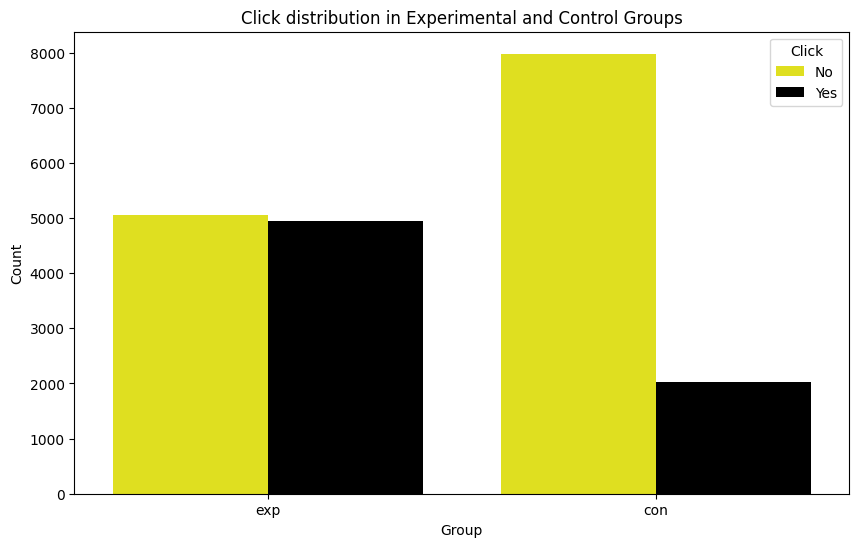

In [82]:
#custom palette for yellow and black
palette = {0: 'yellow', 1: 'black'} #0 - no-click 1-click

#plotting the click distribution for each group with the custom colours
plt.figure(figsize=(10, 6))
ax = sns.countplot(x = 'group', hue='click', data = df_ab_test, palette=palette)
plt.title('Click distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title = 'Click', labels = ['No', 'Yes'])

group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

# Parameters of the model from Power Analysis

In [83]:
alpha = 0.05
print(f"Alpha: significance level is {alpha}")

delta = 0.1
print(f"Delta minimum detectable effect is {delta}")

Alpha: significance level is 0.05
Delta minimum detectable effect is 0.1


# Calculating total number of clicks per group by summing clicks

In [84]:
# Calculate the number of users in each group
N_con = df_ab_test[df_ab_test["group"] == "con"].shape[0]  # Number of users in control group
N_exp = df_ab_test[df_ab_test["group"] == "exp"].shape[0]  # Number of users in experimental group

# Calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# Printing this for visibility
print(df_ab_test.groupby("group")["click"].sum())
print(f"No. of users in Control: {N_con}")
print(f"No. of users in Experimental: {N_exp}")
print(f"No. of clicks in Control: {X_con}")
print(f"No. of clicks in Experimental: {X_exp}")

group
con    2019
exp    4940
Name: click, dtype: int64
No. of users in Control: 10000
No. of users in Experimental: 10000
No. of clicks in Control: 2019
No. of clicks in Experimental: 4940


Calulating pooled estimates for clicks per group

In [85]:
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp

print(f"Click probability in Control Group: {p_con_hat}")
print(f"Click probability in Experimental Group: {p_exp_hat}")

#computing the estimate of pooled clicked probability
p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)

print(f"Pooled probability = {p_pooled_hat}")

Click probability in Control Group: 0.2019
Click probability in Experimental Group: 0.494
Pooled probability = 0.34795


Calculating Pooled Variance

In [86]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)

print(f"p^_pooled is {pooled_variance}")

p^_pooled is 4.53761595e-05


Calculating Standard Error and Test Statistics

In [87]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard error is ", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test statistics for 2-sample Z-test is ", Test_stat)

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal Distribution ", Z_crit)

Standard error is  0.006736182858266245
Test statistics for 2-sample Z-test is  -43.36283710611451
Z-critical value from Standard Normal Distribution  1.959963984540054


# Calculating p_values of the Z-test
* A low p-value (p<=0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
* A high p-value (p>0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [88]:
# calculating the p-value
p_value = norm.sf(abs(Test_stat))*2
print(p_value)

# function checking the statistical significance

def is_statistical_significance(p_value, alpha):
    '''
    We assess whether there is statistical siginificance based on the p-value and alpha.

    Arguments:
     - p-value (float): The p-value resulting from the statistical test
     - alpha (float, optional): The significance level threshold used to determine statistical siginificance. Defaults to 0.05.

    Returns:
        Prints the assessment of statistical siginificance.
    '''

    # print the rounded p-value to 3-decimal places
    print(f"P-value of the 2-sample Z-test is {np.round(p_value, 3)}")

    # determine statistical siginficance
    if p_value < alpha:
        print("There is statistical siginificance, indicating that the observed differences between the groups are unlikely to have occured. \nThis suggests that the new feature of the landing page (Enroll now) is better and results in higher click rate.")
    else:
        print("There is no statistical siginificance, suggesting that the observed differences between the groups could have occured randomly.")

is_statistical_significance(p_value, alpha)

0.0
P-value of the 2-sample Z-test is 0.0
There is statistical siginificance, indicating that the observed differences between the groups are unlikely to have occured. 
This suggests that the new feature of the landing page (Enroll now) is better and results in higher click rate.


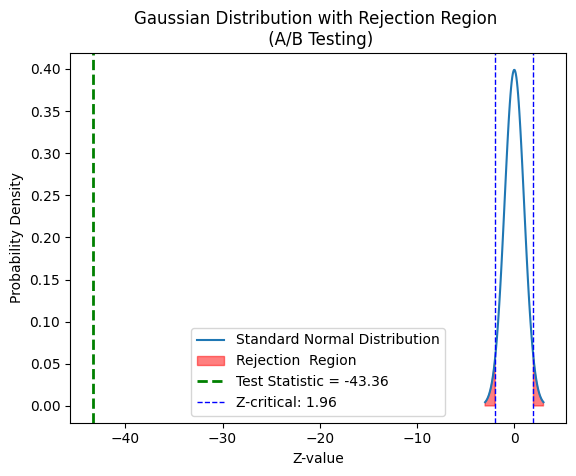

In [89]:
# parameters for the standard normal distribution
mu = 0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# plotting the standard normal distribution
plt.plot(x, y, label = 'Standard Normal Distribution')
# shade the rejection region for a two tailed test
plt.fill_between(x, y, where=(x>Z_crit)|(x<-Z_crit), color='red', alpha=0.5, label='Rejection  Region')
# adding the test statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat: .2f}')
# adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical: {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing)')
plt.legend()

plt.show()

# Calculate the Confidence Interval of the test

In [90]:
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3),
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)
]

print(f"Confidence interval of the 2 sample Z-test is {CI}")

Confidence interval of the 2 sample Z-test is [0.279, 0.305]


# Testing for Practical Siginificance in A/B Testing

In [93]:
def is_Practically_significant(delta, CI_95):
    '''
    We assess here if the difference between the Control and Experimental group is practically siginificant using the Minimum Detectable Effect(MDE).
    
    Arguments:
        -delta (float): The MDE considered for practical siginificance
        -CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval
    
    Returns:
        -Prints whether the experiment has practical significance based on the MDE and CI.
    '''

    # extract the lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    #check if the lower bound of the CI is greater than or equal to delta
    if delta>=lower_bound_CI:
        print(f"We have practical siginificance. With MDE of {delta}, The difference between Control and Experimental Group id siginificant.")
        return True
    else:
        print("We don't have practical siginificance. The difference between Control and Experimental group is not practically siginificant.")
        return False

CI_95 = (0.279, 0.305)
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence level is ", CI_95[0])



We don't have practical siginificance. The difference between Control and Experimental group is not practically siginificant.
Lower bound of 95% confidence level is  0.279
